<a href="https://colab.research.google.com/github/kashperova/iasa-nlp-course/blob/main/assignment_2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install demoji contractions dython Unidecode textstat transformers

In [ ]:
!pip install sentence_transformers

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import demoji
import contractions
import matplotlib.pyplot as plt
from dython import nominal
from textblob import TextBlob
from textblob import TextBlob, Word
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from textstat import flesch_kincaid_grade
import torch
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

I didn't copy all code cells with previous EDA from first assignment. However, I will refer to the previous solution in the comments.

In [ ]:
prompts_train_df = pd.read_csv("/content/prompts_train.csv")
summaries_train_df = pd.read_csv("/content/summaries_train.csv")

In [ ]:
prompts_test_df = pd.read_csv("/content/prompts_test.csv")
summaries_test_df = pd.read_csv("/content/summaries_test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

### Summaries columns
<br>
<li>student_id - The ID of the student writer.</li>
<li>prompt_id - The ID of the prompt which links to the prompt file.</li>
<li>text - The full text of the student's summary.</li>
<li>content - The content score for the summary. The first target.</li>
<li>wording - The wording score for the summary. The second target.</li>

In [ ]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Prompts columns
<br>
<li>prompt_id - The ID of the prompt which links to the summaries file.</li>
<li>prompt_question - The specific question the students are asked to respond to.</li>
<li>prompt_title - A short-hand title for the prompt.</li>
<li>prompt_text - The full prompt text.</li>

In [ ]:
prompts_train_df.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


## Data Processing

I tried to improve data processing and feature selection from previous solution. I added stemming as text preprocessing technique.

In [ ]:
class TextPreprocessor:
    def __init__(self, links=True, email=False, cyrillic=False,
                 markdown=True, emoji=True, unicode=True,
                 stopwords=False, punkt=True, to_lower=False,
                 contractions=True, numbers=True,
                 stemming=False
                ):
        self.remove_links = links
        self.remove_email = email
        self.remove_cyrillic = cyrillic
        self.remove_markdown = markdown
        self.remove_emoji = emoji
        self.remove_unicode = unicode
        self.remove_stopwords = stopwords
        self.remove_punkt = punkt
        self.to_lower = to_lower
        self.remove_contractions = contractions
        self.remove_numbers = numbers
        self.stemming = stemming

    def __call__(self, text):
        for attr_name, attr_value in vars(self).items():
            if callable(getattr(TextPreprocessor, "_" + attr_name)) and attr_value:
                text = getattr(self, "_" + attr_name)(text)
        return text

    @staticmethod
    def _stemming(text: str):
      tokens = word_tokenize(text)
      tokens = [word for word in tokens if word.isalnum()]
      stemmer = PorterStemmer()
      stemmed_tokens = [stemmer.stem(word) for word in tokens]
      text = ' '.join(stemmed_tokens)
      return text

    @staticmethod
    def _remove_links(text: str):
        return re.sub(r"http\S+", "", text)

    @staticmethod
    def _remove_email(text: str):
        return re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b", "", text)

    @staticmethod
    def _remove_cyrillic(text: str):
        return re.sub(r"[а-яА-Я]+", "", text)

    @staticmethod
    def _remove_punkt(text: str):
        return re.sub(r"[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]+", " ", text)

    @staticmethod
    def _remove_markdown(text: str):
        patterns = [r"={2,}", r"-{2,}", r"#+", r"\n{3,}"]
        for pattern in patterns:
            text = re.sub(pattern, "", text)
        return text

    @staticmethod
    def _remove_emoji(text: str):
        return demoji.replace(text, "")

    @staticmethod
    def _remove_unicode(text: str):
        return unidecode(text, errors="preserve")

    @staticmethod
    def _remove_stopwords(text: str):
        words = word_tokenize(text)
        english_stopwords = set(stopwords.words('english'))
        filtered_words = [word for word in words if word.lower() not in english_stopwords]
        return ' '.join(filtered_words)

    @staticmethod
    def _to_lower(text: str):
        return text.lower()

    @staticmethod
    def _remove_contractions(text: str):
        return contractions.fix(text)

    @staticmethod
    def _remove_numbers(text: str):
        return re.sub(r"\d+", "", text)

In [ ]:
print(prompts_train_df.iloc[0]["prompt_text"])

Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, doubtle

In [ ]:
tp = TextPreprocessor(email=True, to_lower=True, stemming=True)
processed_text = tp(prompts_train_df.iloc[0]["prompt_text"])
print(processed_text)

chapter as the sequel to what ha alreadi been said we must proceed to consid what the poet should aim at and what he should avoid in construct hi plot and by what mean the specif effect of tragedi will be produc a perfect tragedi should as we have seen be arrang not on the simpl but on the complex plan it should moreov imit action which excit piti and fear thi be the distinct mark of tragic imit it follow plainli in the first place that the chang of fortun present must not be the spectacl of a virtuou man brought from prosper to advers for thi move neither piti nor fear it mere shock us nor again that of a bad man pass from advers to prosper for noth can be more alien to the spirit of tragedi it possess no singl tragic qualiti it neither satisfi the moral sens nor call forth piti or fear nor again should the downfal of the utter villain be exhibit a plot of thi kind would doubtless satisfi the moral sens but it would inspir neither piti nor fear for piti is arous by unmerit misfortun f

In [ ]:
prompts_train_df["cleaned_prompt_text"] = prompts_train_df["prompt_text"].apply(lambda x: tp(x))

In [ ]:
summaries_tp = TextPreprocessor(email=True, to_lower=True, numbers=False, stemming=True)
summaries_train_df["cleaned_summary_text"] = summaries_train_df["text"].apply(lambda x: summaries_tp(x))

In [ ]:
prompts_train_df["cleaned_prompt_question"] = prompts_train_df["prompt_question"].apply(lambda x: summaries_tp(x))
prompts_train_df["cleaned_prompt_title"] = prompts_train_df["prompt_title"].apply(lambda x: summaries_tp(x))

## Feature Engineering

According to previos EDA notebook I added new features - <b>amount of sentences, paragraphs in initial prompt_text, amount of sentences and paragraphs in student's summary</b>. Also such features as <b>cite evidence,  proposed in prompt text, mistake's amount in summary</b> were created.



<b>Mistakes</b> were counted using TextBlob library, using predefined spelling correction.

In [ ]:
paragraphs = {}
for prompt_id in list(prompts_train_df["prompt_id"].unique()):
    paragraphs[prompt_id] = len(prompts_train_df[prompts_train_df["prompt_id"]==prompt_id]["prompt_text"].values)

In [ ]:
summaries_train_df["prompt_paragraphs"] = summaries_train_df["prompt_id"].apply(lambda x: paragraphs[x])

In [ ]:
sentences = {}
for prompt_id in list(prompts_train_df["prompt_id"].unique()):
    sentences[prompt_id] = len(prompts_train_df[prompts_train_df["prompt_id"]==prompt_id]["prompt_text"].values[0].split("."))

In [ ]:
summaries_train_df["prompt_sentences"] = summaries_train_df["prompt_id"].apply(lambda x: sentences[x])

In [ ]:
cite = {}
for prompt_id in list(prompts_train_df["prompt_id"].unique()):
    cite[prompt_id] = "cite" in prompts_train_df[prompts_train_df["prompt_id"]==prompt_id]["prompt_question"].values[0].lower()

In [ ]:
summaries_train_df["cite"] = summaries_train_df["prompt_id"].apply(lambda x: cite[x])

In [ ]:
summaries_train_df["n_sentences"] = summaries_train_df["text"].apply(lambda x: len(x.split(".")))
summaries_train_df["n_paragraphs"] = summaries_train_df["text"].apply(lambda x: len(x.split("\n")))

In [ ]:
def count_mistakes(text):
    orig_words = text.split()
    fixed_words = TextBlob(text).correct().split()
    return len([(x,y) for x,y in zip(orig_words, fixed_words) if x != y])

In [ ]:
summaries_train_df["mistakes"] = summaries_train_df["text"].apply(lambda x: count_mistakes(x))

In [ ]:
summaries_train_df["cleaned_prompt_question"] = summaries_train_df["prompt_id"].apply(lambda x: prompts_train_df[prompts_train_df["prompt_id"]==x]["cleaned_prompt_question"].values[0])
summaries_train_df["cleaned_prompt_title"] = summaries_train_df["prompt_id"].apply(lambda x: prompts_train_df[prompts_train_df["prompt_id"]==x]["cleaned_prompt_title"].values[0])
summaries_train_df["cleaned_prompt_text"] = summaries_train_df["prompt_id"].apply(lambda x: prompts_train_df[prompts_train_df["prompt_id"]==x]["cleaned_prompt_text"].values[0])

In [ ]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording,cleaned_summary_text,prompt_paragraphs,prompt_sentences,cite,mistakes,n_sentences,n_paragraphs,cleaned_prompt_question,cleaned_prompt_title,cleaned_prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,the third wave wa an experimentto see how peop...,7,28,0,3,4,1,summar how the third wave develop over such a ...,the third wave,background the third wave experi took place at...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,they would rub it up with soda to make the sme...,5,25,1,1,3,1,summar the variou way the factori would use or...,excerpt from the jungl,with one member trim beef in a canneri and ano...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,in egypt there were mani occup and social clas...,17,44,1,9,13,1,in complet sentenc summar the structur of the ...,egyptian social structur,egyptian societi wa structur like a pyramid at...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,the highest class wa pharaoh these peopl were ...,17,44,1,4,5,1,in complet sentenc summar the structur of the ...,egyptian social structur,egyptian societi wa structur like a pyramid at...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,the third wave develop rapidli becaus the stud...,7,28,0,23,14,1,summar how the third wave develop over such a ...,the third wave,background the third wave experi took place at...


At this solution I decided to add new features. <br>
- <b>amount of punctuation in student's summary</b>
- <b>amount of unqiue words in student's summary</b>
- <b>amount of adjectives and adverbs in student's summary</b>
- <b>Flesch-Kincaid readability score</b> (I only found out about this score while doing this assignment. Essentially, it's a measure of how difficult it is for a reader to perceive a text. <a href="https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests">more</a>)

In [ ]:
def count_adj_adv(text):
    tagged = pos_tag(word_tokenize(text))
    adj_adv_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    return sum(1 for word, tag in tagged if tag in adj_adv_tags)

In [ ]:
summaries_train_df['punctuation_count'] = summaries_train_df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

summaries_train_df['unique_word_count'] = summaries_train_df['text'].apply(lambda x: len(set(word_tokenize(x.lower()))))

summaries_train_df['adj_adv_count'] = summaries_train_df['text'].apply(count_adj_adv)

summaries_train_df['fk_score'] = summaries_train_df['text'].apply(flesch_kincaid_grade)

In [ ]:
summaries_train_df.head()

,student_id,prompt_id,text,content,wording,cleaned_summary_text,prompt_paragraphs,prompt_sentences,cite,mistakes,n_sentences,n_paragraphs,cleaned_prompt_question,cleaned_prompt_title,cleaned_prompt_text,punctuation_count,unique_word_count,adj_adv_count,fk_score
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,the third wave was an experimentto see how peo...,7,28,0,3,4,1,summarize how the third wave developed over su...,the third wave,background \r\nthe third wave experiment took ...,3,50,9,8.1
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,they would rub it up with soda to make the sme...,5,25,1,1,3,1,summarize the various ways the factory would u...,excerpt from the jungle,"with one member trimming beef in a cannery, an...",2,36,6,7.5
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"in egypt, there were many occupations and soci...",17,44,1,9,13,1,"in complete sentences, summarize the structure...",egyptian social structure,egyptian society was structured like a pyramid...,38,142,25,8.5
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,the highest class was pharaohs these people we...,17,44,1,4,5,1,"in complete sentences, summarize the structure...",egyptian social structure,egyptian society was structured like a pyramid...,6,21,3,5.3
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,the third wave developed rapidly because the ...,7,28,0,23,14,1,summarize how the third wave developed over su...,the third wave,background \r\nthe third wave experiment took ...,30,133,18,7.8


## Correlation matrix

<Axes: >

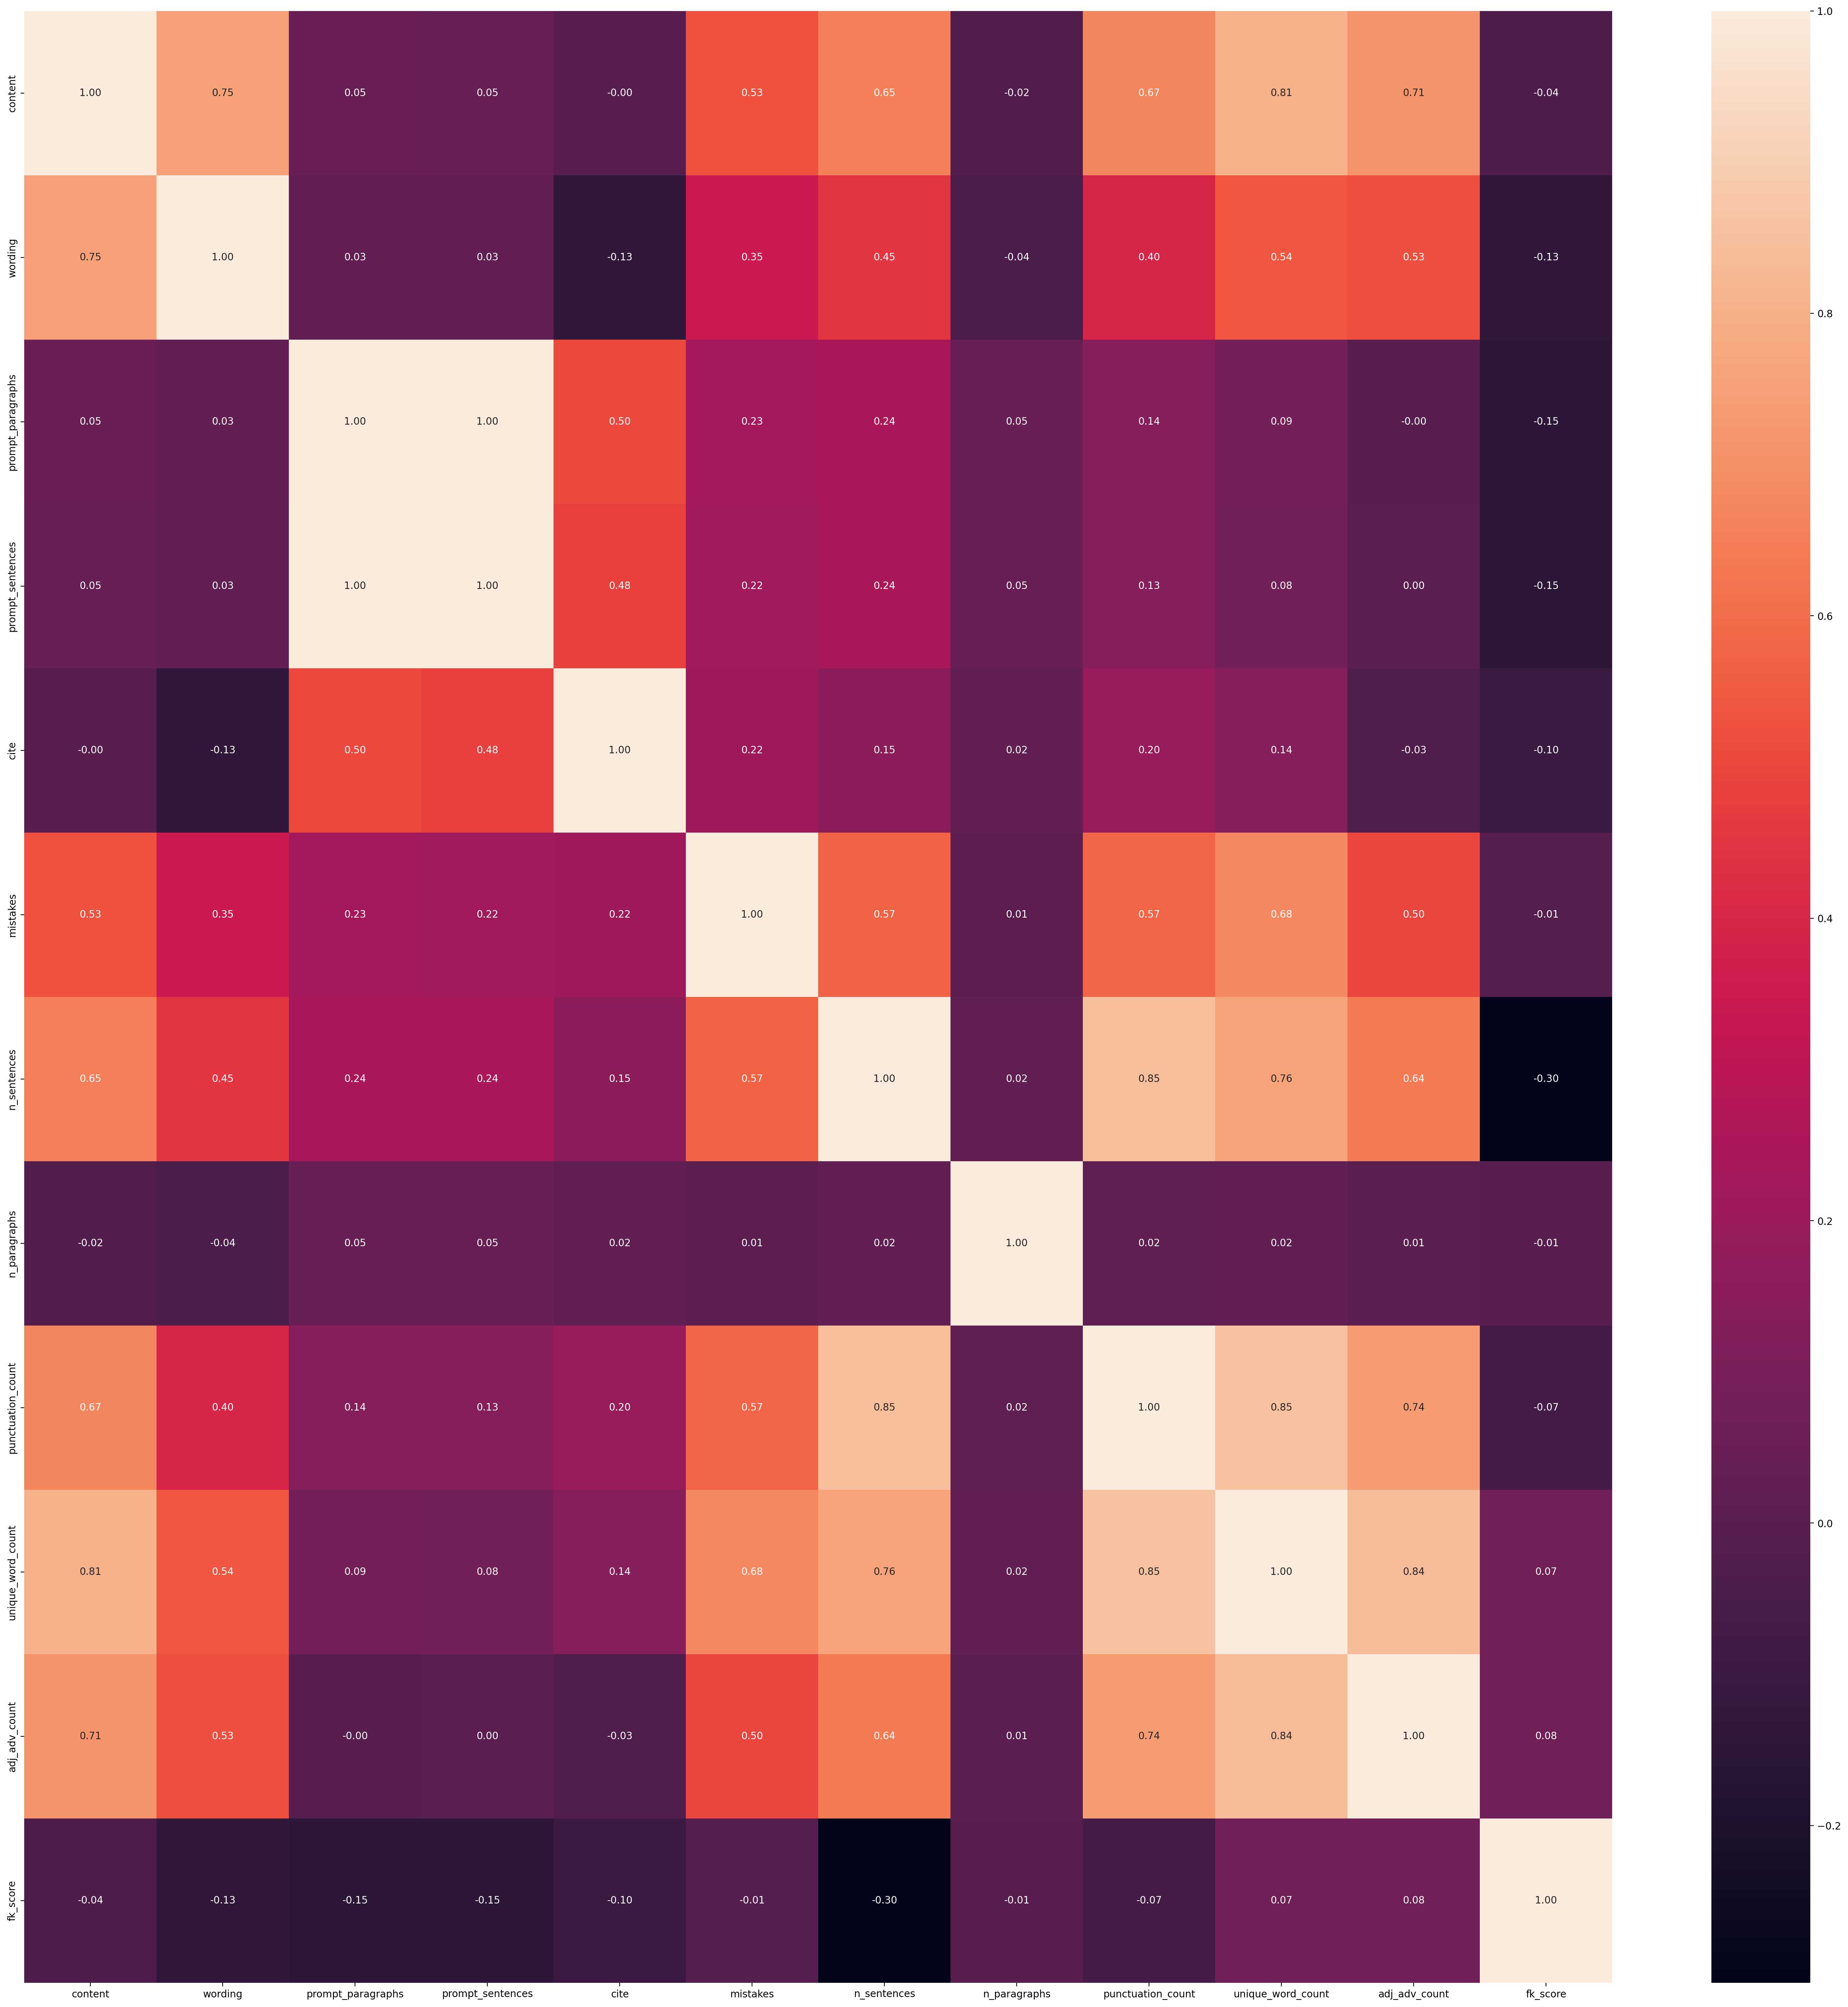

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(36,36), dpi = 200)
sns.heatmap(summaries_train_df.select_dtypes(include=['number', 'float', 'int']).corr(), annot = True, fmt = '.2f')

According to correlation matrix before training I decided to remain for <b>content</b> such features as: <br>
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>punctuation_count</b> - amount of punctuation in student's summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary

For <b>wording</b> such features as: <br>
- <b>cite</b> - whether is proposed in prompt question to cite evidence from the text.
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>punctuation_count</b> - amount of punctuation in student's summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary
- <b>fk_score</b> - Flesch-Kincaid readability score in student's summary

In [ ]:
text_columns = ['cleaned_summary_text', 'cleaned_prompt_question', 'cleaned_prompt_title', 'cleaned_prompt_text']

In [ ]:
selected_columns_content = ['content', 'mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count']
content_train = summaries_train_df[selected_columns_content]
content_train["text"] =  summaries_train_df['cleaned_summary_text'].astype(str) + summaries_train_df['cleaned_prompt_question'].astype(str) + summaries_train_df['cleaned_prompt_title'].astype(str) + summaries_train_df['cleaned_prompt_text'].astype(str)
content_train.head()

<ipython-input-9-3a219c5520c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_train["text"] =  summaries_train_df['cleaned_summary_text'].astype(str) + summaries_train_df['cleaned_prompt_question'].astype(str) + summaries_train_df['cleaned_prompt_title'].astype(str) + summaries_train_df['cleaned_prompt_text'].astype(str)


,content,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,text
0,0.205683,3,4,3,50,9,the third wave was an experimentto see how peo...
1,-0.548304,1,3,2,36,6,they would rub it up with soda to make the sme...
2,3.128928,9,13,38,142,25,"in egypt, there were many occupations and soci..."
3,-0.210614,4,5,6,21,3,the highest class was pharaohs these people we...
4,3.272894,23,14,30,133,18,the third wave developed rapidly because the ...


In [ ]:
selected_columns_wording = ['wording',  'cite', 'mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count', 'fk_score']
wording_train = summaries_train_df[selected_columns_wording]
wording_train["text"] = content_train["text"]
wording_train.head()

<ipython-input-10-d58eae8e0897>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wording_train["text"] = content_train["text"]


,wording,cite,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,fk_score,text
0,0.380538,0,3,4,3,50,9,8.1,the third wave was an experimentto see how peo...
1,0.506755,1,1,3,2,36,6,7.5,they would rub it up with soda to make the sme...
2,4.231226,1,9,13,38,142,25,8.5,"in egypt, there were many occupations and soci..."
3,-0.471415,1,4,5,6,21,3,5.3,the highest class was pharaohs these people we...
4,3.219757,0,23,14,30,133,18,7.8,the third wave developed rapidly because the ...


## Modeling

### Sentence Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")
content_train['text_embeddings'] = content_train['text'].apply(lambda x: sent_tr.encode(x))

<ipython-input-14-c0f1038ea60a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_train['text_embeddings'] = content_train['text'].apply(lambda x: sent_tr.encode(x))


In [ ]:
content_train = pd.concat([summaries_train_df["prompt_id"], content_train], axis=1)
content_train.head()

,prompt_id,content,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,text,text_embeddings
0,814d6b,0.205683,3,4,3,50,9,the third wave was an experimentto see how peo...,"[-0.036672298, -0.0704272, -0.07790265, -0.013..."
1,ebad26,-0.548304,1,3,2,36,6,they would rub it up with soda to make the sme...,"[-0.0652894, 0.083049566, 0.029189045, 0.05462..."
2,3b9047,3.128928,9,13,38,142,25,"in egypt, there were many occupations and soci...","[-0.10015618, 0.08963002, 0.025349244, 0.00059..."
3,3b9047,-0.210614,4,5,6,21,3,the highest class was pharaohs these people we...,"[-0.079644725, 0.07215832, 0.016362019, -0.017..."
4,814d6b,3.272894,23,14,30,133,18,the third wave developed rapidly because the ...,"[-0.041464534, -0.077769995, -0.0806523, -0.03..."


In [ ]:
wording_train['text_embeddings'] = content_train['text_embeddings']

<ipython-input-16-318a772279fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wording_train['text_embeddings'] = content_train['text_embeddings']


In [ ]:
wording_train = pd.concat([summaries_train_df["prompt_id"], wording_train], axis=1)
wording_train.head()

,prompt_id,wording,cite,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,fk_score,text,text_embeddings
0,814d6b,0.380538,0,3,4,3,50,9,8.1,the third wave was an experimentto see how peo...,"[-0.036672298, -0.0704272, -0.07790265, -0.013..."
1,ebad26,0.506755,1,1,3,2,36,6,7.5,they would rub it up with soda to make the sme...,"[-0.0652894, 0.083049566, 0.029189045, 0.05462..."
2,3b9047,4.231226,1,9,13,38,142,25,8.5,"in egypt, there were many occupations and soci...","[-0.10015618, 0.08963002, 0.025349244, 0.00059..."
3,3b9047,-0.471415,1,4,5,6,21,3,5.3,the highest class was pharaohs these people we...,"[-0.079644725, 0.07215832, 0.016362019, -0.017..."
4,814d6b,3.219757,0,23,14,30,133,18,7.8,the third wave developed rapidly because the ...,"[-0.041464534, -0.077769995, -0.0806523, -0.03..."


## SVR

In the previous assignment I didn't pay attention that in test dataset will be a lot of new prompts. That's why as lecturers said we need to use in validation samples only from one prompt.
As lecturers advised, I use one prompt for validation, and others - for training.  

### Content

In [ ]:
selected_columns_content.remove("content")

In [ ]:
X = pd.concat([pd.DataFrame(content_train['text_embeddings'].to_list()), content_train[selected_columns_content]], axis=1)
X.columns = [str(x) for x in X.columns]
y = content_train['content']
groups = content_train['prompt_id']

svr_content = SVR(kernel='rbf', C=1)
group_kfold = GroupKFold(n_splits=3)
rmse_scores = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svr_content.fit(X_train, y_train)
    y_pred = svr_content.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    rmse_scores.append(rmse)

In [ ]:
for idx, rmse in enumerate(rmse_scores, 1):
    print(f"Fold {idx} - Root Mean Squared Error: {rmse:.4f}")

avg_rmse_content = sum(rmse_scores) / len(rmse_scores)
print(f"Average RMSE across all folds (Content): {avg_rmse_content:.4f}")

Fold 1 - Root Mean Squared Error: 0.4932
Fold 2 - Root Mean Squared Error: 0.5883
Fold 3 - Root Mean Squared Error: 0.5678
Average RMSE across all folds (Content): 0.5498


In [ ]:
with open('svr_content.pkl','wb') as f:
    pickle.dump(svr_content, f)

### Wording

In [ ]:
selected_columns_wording.remove("wording")

In [ ]:
X = pd.concat([pd.DataFrame(wording_train['text_embeddings'].to_list()), wording_train[selected_columns_wording]], axis=1)
X.columns = [str(x) for x in X.columns]
y = wording_train['wording']
groups = wording_train['prompt_id']

svr_wording = SVR(kernel='rbf', C=1)
group_kfold = GroupKFold(n_splits=3)
rmse_scores = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    svr_wording.fit(X_train, y_train)
    y_pred = svr_wording.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    rmse_scores.append(rmse)

In [ ]:
for idx, rmse in enumerate(rmse_scores, 1):
    print(f"Fold {idx} - Root Mean Squared Error: {rmse:.4f}")

avg_rmse_wording = sum(rmse_scores) / len(rmse_scores)
print(f"Average RMSE across all folds (Wording): {avg_rmse_wording:.4f}")

Fold 1 - Root Mean Squared Error: 0.7178
Fold 2 - Root Mean Squared Error: 0.8532
Fold 3 - Root Mean Squared Error: 0.8672
Average RMSE across all folds (Wording): 0.8128


In [ ]:
with open('svr_wording.pkl','wb') as f:
    pickle.dump(svr_wording, f)

Final metric:

In [ ]:
mcrmse = (avg_rmse_content + avg_rmse_wording) / 2
print(f"MCRMSE: {mcrmse:.4f}")

MCRMSE: 0.6813


## Submission to Kaggle

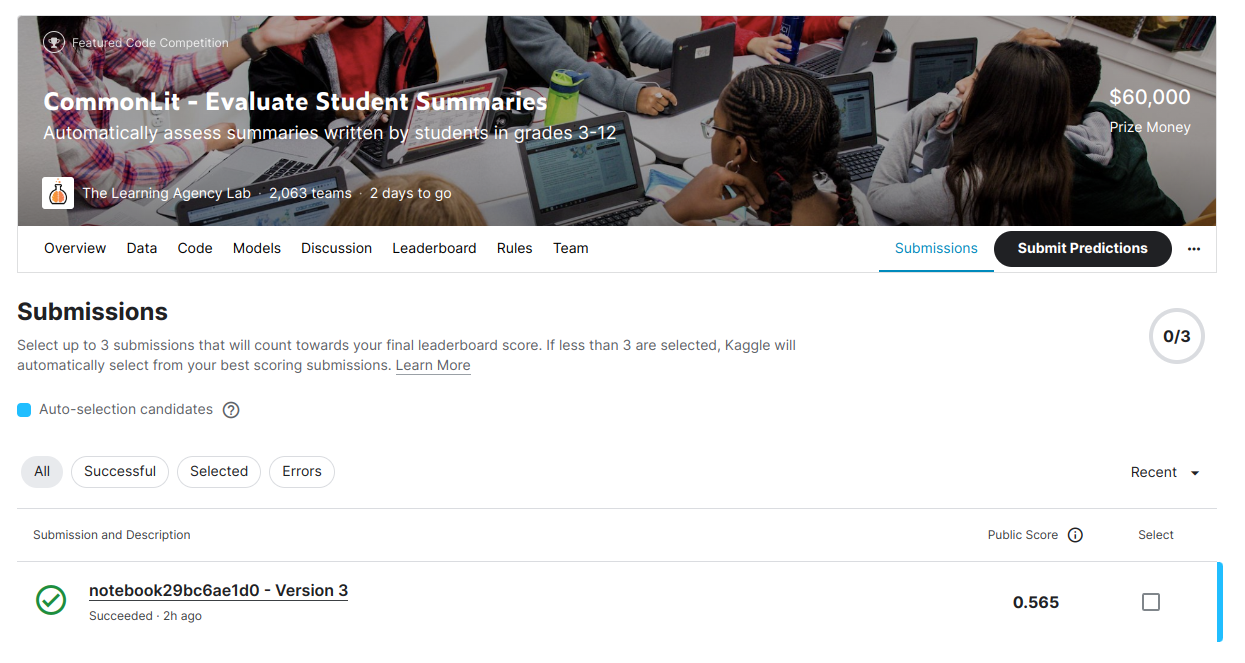

Kaggle Notebook with submission - <a href="https://www.kaggle.com/code/skashperova/notebook29bc6ae1d0">here</a>